## Metacognition task ERP analysis: pre-processing, ERP analysis, data visualisation
An example of visualising metacognition task data at one channel.

In [4]:
# Import packages
import mne, os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Set the default directory
os.chdir('/Users/aliciacampbell/GitHub/pyline/EEG-pyline/')

# Ignore warnings from plotting and display only errors for MNE
mne.set_log_level('error')

# Import functions
import basic.arrange_data as arrange
import signal_processing.pre_process as pre_process
import signal_processing.erp_analysis as erpan

**Locating the EEG files in folders** by define the experiment sub-folder (`exp_folder`), folder with raw EEG files (`raw_folder`), folder for exporting clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`).

During pre-processing, all the raw EEG files are cleaned from the `raw_folder/exp_folder` and later saved to `clean_folder/exp_folder`. For analysis, the same clean files are read in and worked on until the results are exported to `results_folder/exp_folder`.

In [5]:
### DEFINE ###
raw_folder = 'Data/Raw/'
clean_folder = 'Data/Clean/'
results_folder = 'Results/'

exp_folder = 'METACOG/Memory/B1'
exp_condition = 'M_B1'

## Pre-processing

**Pre-processing** within this study includes initially reading the raw EEG files from `raw_folder/exp_folder`, setting montage (`biosemi32`), re-referencing the signals to `mastoid`, cropping the EEG signal to include only the `resting` part.

Furthermore, `0.5-30 Hz FIR filter` is designed (`zero-phase, Hamming window, order 6578`) and EOG channels are used to remove EOG-related noise with `signal-space projections (SSP)` as method.

Finally, artefacts are rejected with Autoreject package by removing epochs which exceed the global thereshold voltage level (`global AR`) and rest of the artefactual epochs are either removed or interpreted with `local AR`.

The clean EEG signals are exported to `clean_folder/exp_folder`.

In [3]:
### DEFINE ###
montage = 'biosemi32'
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'] # EOG channels + mastoids
stimulus_channel = 'Status'
reference = ['EXG1', 'EXG2'] # mastoid channels as reference
epochs_duration = 5
filter_design = dict(l_freq=0.5,h_freq=30,filter_length='auto',method='fir',
                     l_trans_bandwidth='auto',h_trans_bandwidth='auto',
                     phase='zero',fir_window='hamming',fir_design='firwin')

# Epoch time window from event/stimuli
tminmax = [-0.2, 1]

# Baseline correction time window
baseline_correction = 

# Event names with IDs for gratings
# event_dict = {'Grating start': 140,
              'Grating end': 141,
              'Delay end': 144,
              'Shifted left': 173,
              'Shifted right': 172,
              'Correct response': 174,
              'Inorrect response': 175,
              'Confidence 1': 131,
              'Confidence 2': 132,
              'Confidence 3': 133,
              'Confidence 4': 134}

# Set the directory in progress and find all BDF (raw EEG) files in there
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'.bdf')

Files in Data/Raw/METACOG/Memory/B1 read in: 4


In [ ]:

# Loop through all the subjects' directories (EEG files directories)
for i in range(len(file_dirs)):
        # Read in the raw EEG data
        raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                                  stim_channel=stimulus_channel)
        
        # Set 'Erg1' as a miscellaneous channel
        raw.set_channel_types({'Erg1': 'misc'})  # assuming 'Erg1' is a miscellaneous channel

        # Set the right montage (Biosemi32) and set reference as average across all channels
        raw = raw.set_montage(mne.channels.make_standard_montage('biosemi32')).load_data()\
                 .set_eeg_reference(ref_channels='average', verbose=verbose)
    
        # Filter the signal with bandpass filter and remove EOG artefacts with SSP
        filt = pre_process.filter_raw_data(raw,filter_design, line_remove=None, eog_channels=eog_channels,
                                    plot_filt=True, savefig=False)
        
        # Find events from the filtered EEG data and name them
        events = mne.find_events(filt, stim_channel=stimulus_channel, consecutive=False, output='onset')
        buttontarget_events = []

        # Create an array of target tone events which have been responded with a button press
        for m in range(len(events)):
                for n in target_ids:
                        if events[m][2] == n and events[m+1][2] == button_id:
                                buttontarget_events.append(events[m])
        buttontarget_events = np.asarray(buttontarget_events)
        
        # Plot all the events
        %matplotlib inline
        fig = mne.viz.plot_events(buttontarget_events, sfreq=filt.info['sfreq'],
                                first_samp=filt.first_samp, event_id=event_dict)
        fig.subplots_adjust(right=0.7)

        # Create epochs time-locked to target tone events which are followed by button press
        picks = mne.pick_types(filt.info, eeg=True, stim=False)
        epochs = mne.Epochs(filt, buttontarget_events, event_id=event_dict, tmin=tminmax[0],
                            tmax=tminmax[1], baseline=baseline_correction, picks=picks, preload=True)
        
        # Plot the epochs' GFP plot before artefact rejection
        epochs.plot_image(title="GFP without AR ({})".format(subject_names[i]))

        # Use AutoReject to repair and remove epochs which are artefactual
        reject_criteria = get_rejection_threshold(epochs)
        print('Dropping epochs with rejection threshold:',reject_criteria)
        epochs.drop_bad(reject=reject_criteria)

        ar = AutoReject(thresh_method='random_search', random_state=1)
        ar.fit(epochs)
        epochs_ar, reject_log = ar.transform(epochs, return_log=True)

        reject_log.plot('horizontal')

        # Plot the epochs' GFP after artefact rejection
        epochs_ar.average().plot()
        epochs_ar.plot_image(title="GFP with AR ({})".format(subject_names[i]))

        # Display the final epochs object meta-data
        display(epochs_ar)

        # Save the cleaned EEG file as .fif file
        try:
                os.makedirs(export_dir)
        except FileExistsError:
                pass
        try:
                mne.Epochs.save(epochs_ar, fname='{}/{}_clean-epo.fif'.format(export_dir,
                                                                              subject_names[i]),
                                                                              overwrite=True)
        except FileExistsError:
                pass

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Event markers are following:
[[ 22279      0    101]
 [ 25932      0    140]
 [ 26230      0    141]
 ...
 [681606      0    174]
 [682529      0    181]
 [683732      0    133]]
Starting point: 21.7568359375 s
Ending point: 667.70703125 s
Total duration: 645.9501953125 s
---
APPLYING FILTER

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


---
APPLYING SSP FOR EOG-REMOVAL

Running EOG SSP computation
Using EOG channels: EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8
EOG channel index for this subject is: [32 33 34 35 36 37 38 39]
Filtering the data to remove DC offset to help distinguish blinks from saccades


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 225 significant peaks
Number of EOG events detected: 225
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 411 original time points ...
0 bad epochs dropped
Adding projection: eeg--0.200-0.200-PCA-01
Done.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


---
DIVIDING INTO EPOCHS

Not setting metadata
129 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 129 events and 5120 original time points ...
0 bad epochs dropped
---
EPOCHS BEFORE AR



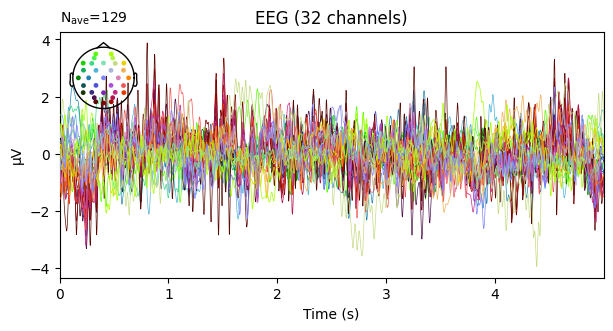

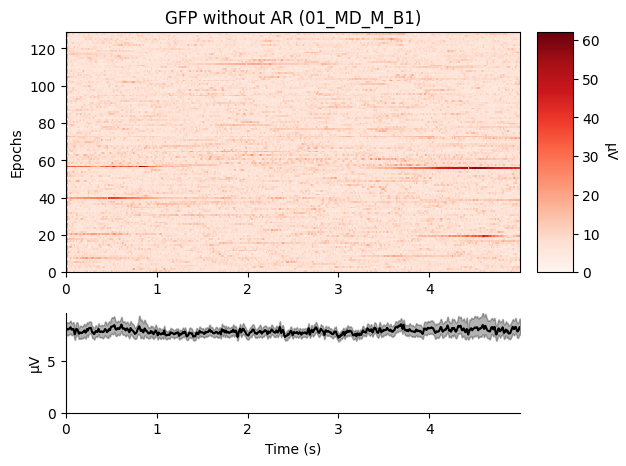

---
APPLYING GLOBAL AR

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.0001858904321965725}
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FC1']
3 bad epochs dropped
---
APPLYING LOCAL AR

Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4


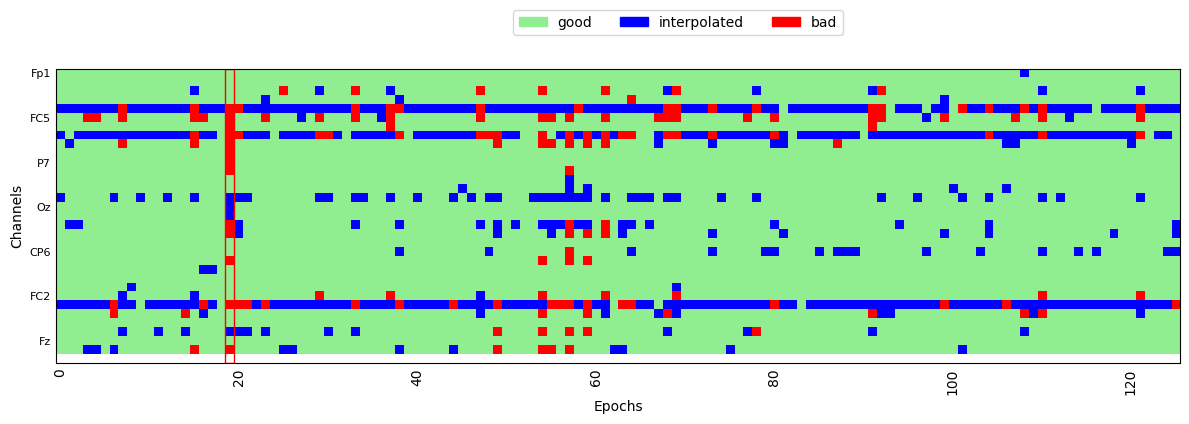

---
EPOCHS AFTER AR



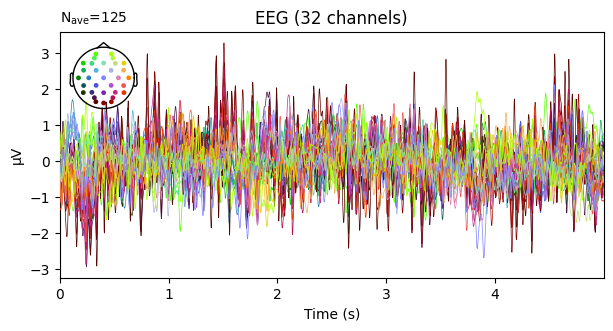

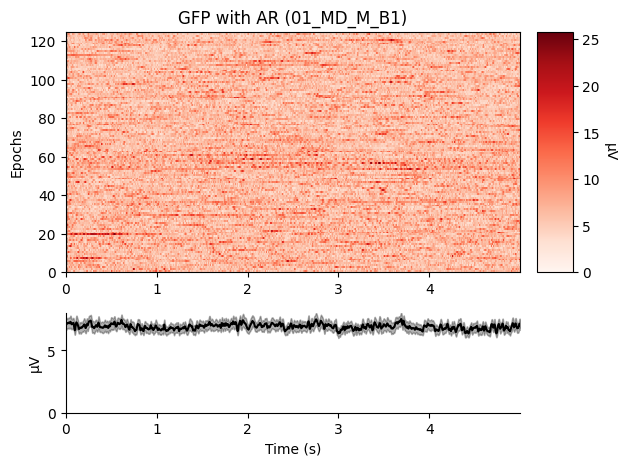

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Event markers are following:
[[ 40202      0    101]
 [ 43599      0    140]
 [ 43899      0    141]
 ...
 [734162      0    174]
 [735085      0    181]
 [736183      0    132]]
Starting point: 39.259765625 s
Ending point: 718.9287109375 s
Total duration: 679.6689453125 s
---
APPLYING FILTER

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


---
APPLYING SSP FOR EOG-REMOVAL

Running EOG SSP computation
Using EOG channels: EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8
EOG channel index for this subject is: [32 33 34 35 36 37 38 39]
Filtering the data to remove DC offset to help distinguish blinks from saccades


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 230 significant peaks
Number of EOG events detected: 230
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 230 events and 411 original time points ...
1 bad epochs dropped
Adding projection: eeg--0.200-0.200-PCA-01
Done.
---
DIVIDING INTO EPOCHS

Not setting metadata
135 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 135 events and 5120 original time points ...


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


0 bad epochs dropped
---
EPOCHS BEFORE AR



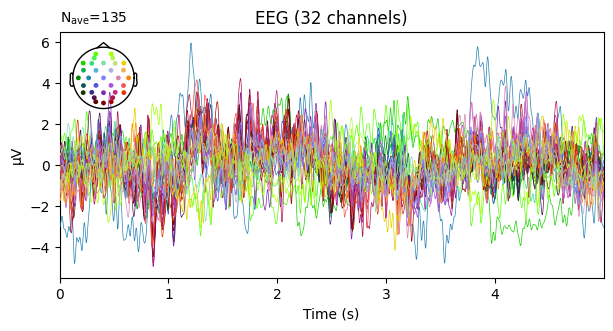

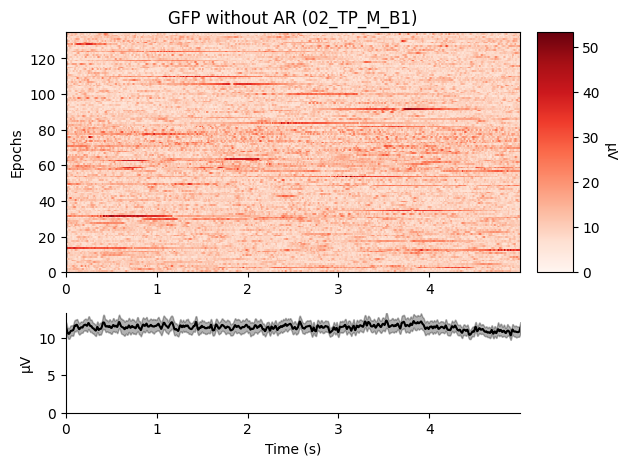

---
APPLYING GLOBAL AR

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.00019482349368525528}
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['

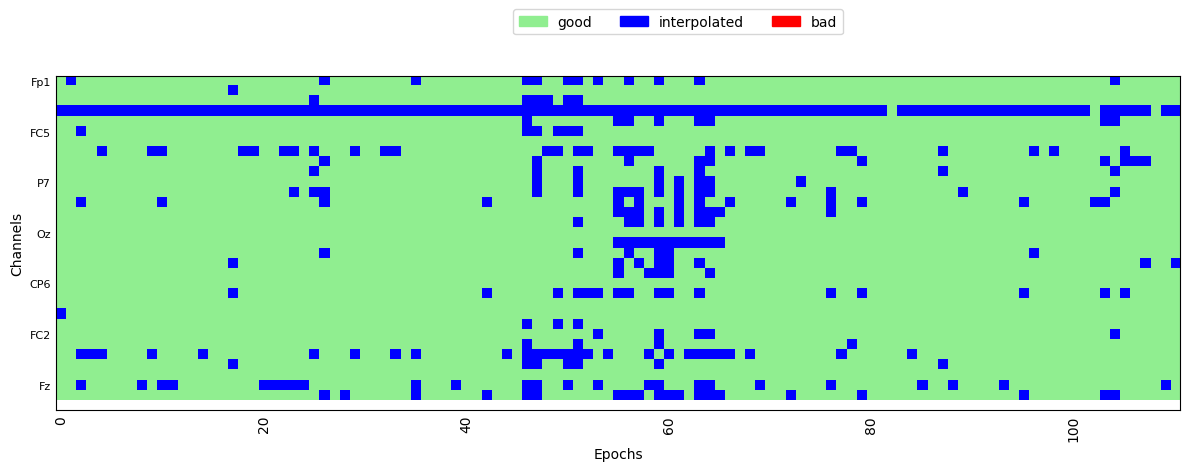

---
EPOCHS AFTER AR



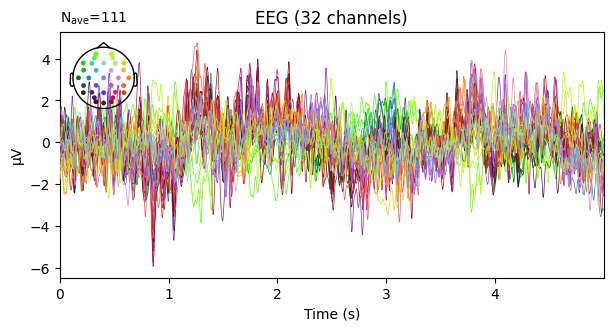

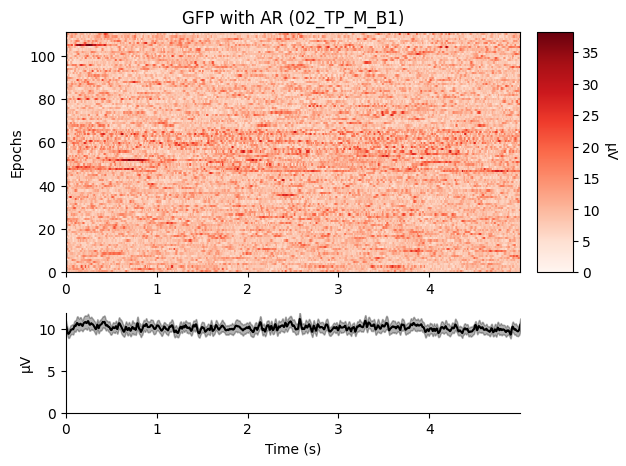

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Event markers are following:
[[ 57184      0    101]
 [ 60322      0    140]
 [ 60620      0    141]
 ...
 [727481      0    175]
 [728404      0    181]
 [729308      0    132]]
Starting point: 55.84375 s
Ending point: 712.21484375 s
Total duration: 656.37109375 s
---
APPLYING FILTER

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


---
APPLYING SSP FOR EOG-REMOVAL

Running EOG SSP computation
Using EOG channels: EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8
EOG channel index for this subject is: [32 33 34 35 36 37 38 39]
Filtering the data to remove DC offset to help distinguish blinks from saccades


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 224 significant peaks
Number of EOG events detected: 224
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 411 original time points ...
0 bad epochs dropped
Adding projection: eeg--0.200-0.200-PCA-01
Done.
---
DIVIDING INTO EPOCHS

Not setting metadata
131 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 131 events and 5120 original time points ...


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


0 bad epochs dropped
---
EPOCHS BEFORE AR



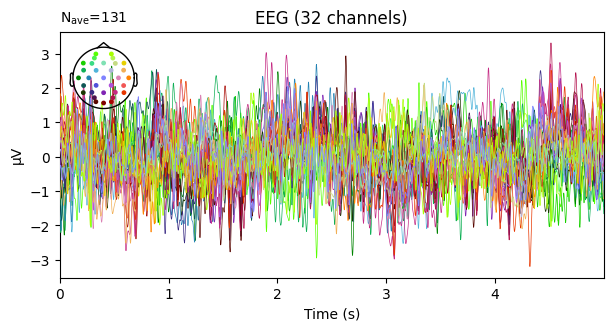

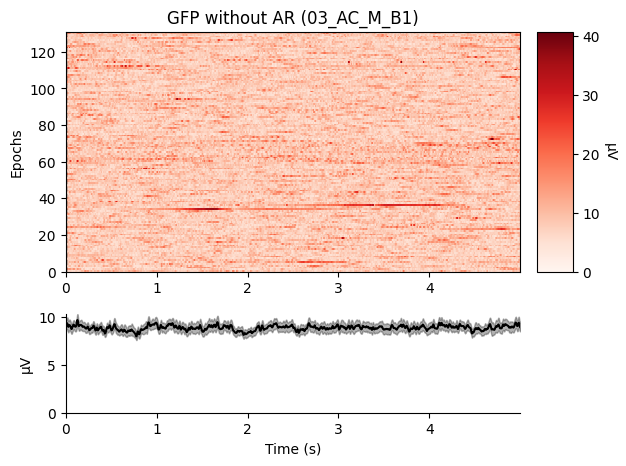

---
APPLYING GLOBAL AR

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.00014009674615209886}
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
7 bad epochs dropped
---
APPLYING LOCAL AR

Running autoreject on ch_type=eeg




Estimated consensus=1.00 and n_interpolate=31
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


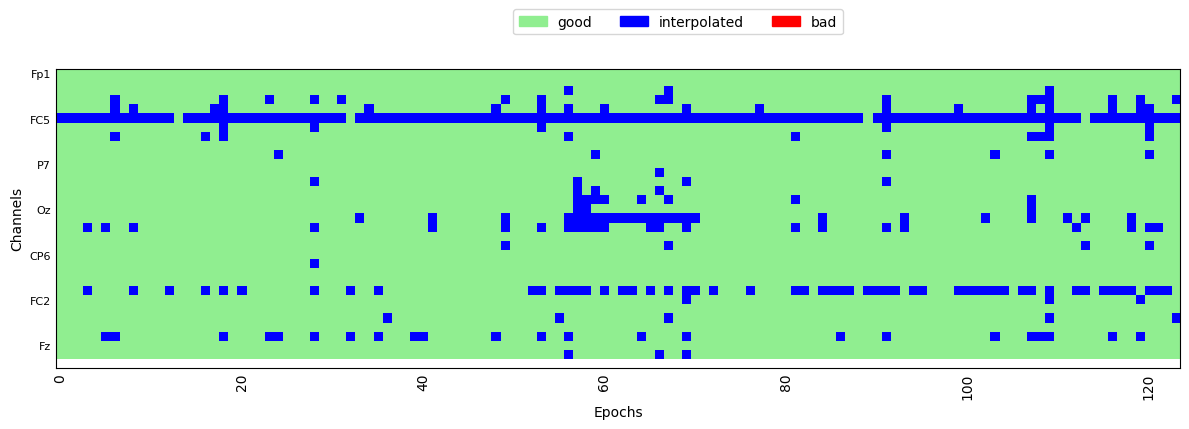

---
EPOCHS AFTER AR



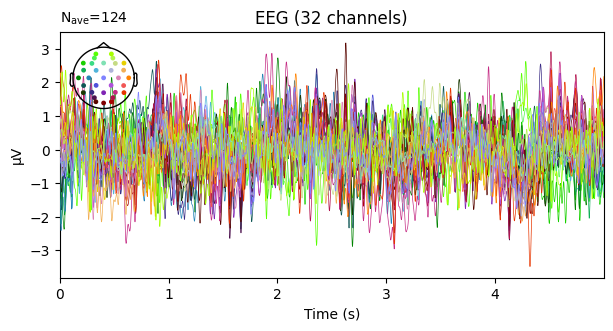

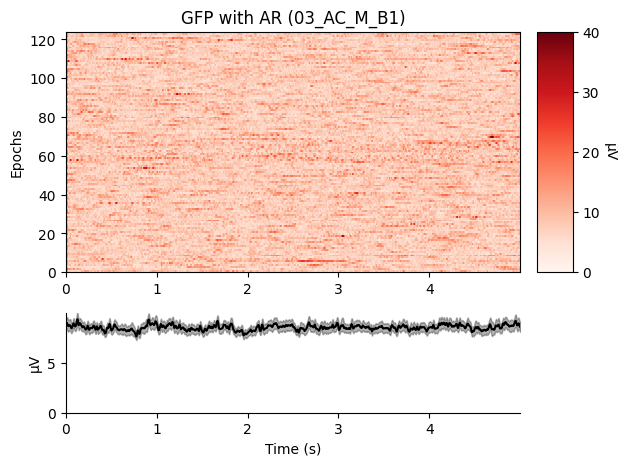

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Event markers are following:
[[ 41783      0    101]
 [ 44914      0    140]
 [ 45213      0    141]
 ...
 [747439      0    174]
 [748362      0    181]
 [750750      0    134]]
Starting point: 40.8037109375 s
Ending point: 733.154296875 s
Total duration: 692.3505859375 s
---
APPLYING FILTER

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


---
APPLYING SSP FOR EOG-REMOVAL

Running EOG SSP computation
Using EOG channels: EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8
EOG channel index for this subject is: [32 33 34 35 36 37 38 39]
Filtering the data to remove DC offset to help distinguish blinks from saccades


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 126 significant peaks
Number of EOG events detected: 126
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 126 events and 411 original time points ...
0 bad epochs dropped
Adding projection: eeg--0.200-0.200-PCA-01
Done.
---
DIVIDING INTO EPOCHS

Not setting metadata
138 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 138 events and 5120 original time points ...


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


0 bad epochs dropped
---
EPOCHS BEFORE AR



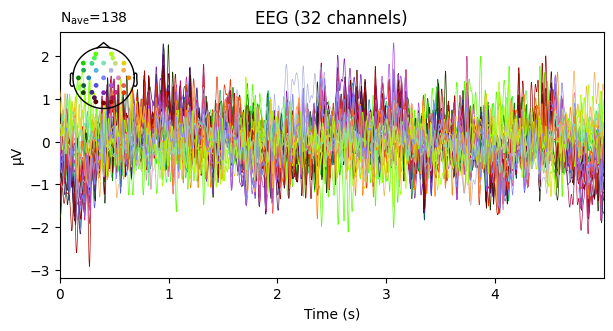

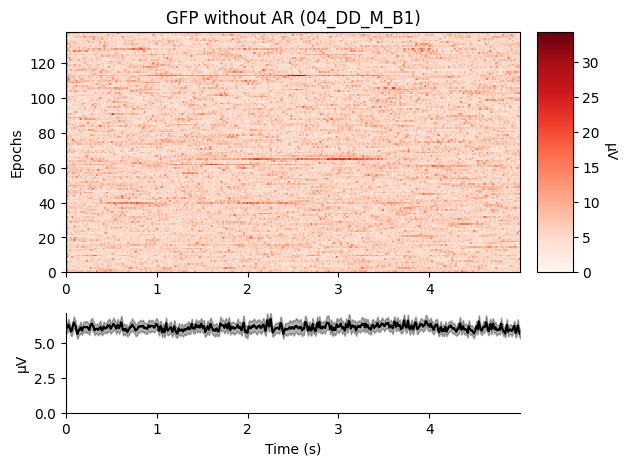

---
APPLYING GLOBAL AR

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.00020033314842130063}
0 bad epochs dropped
---
APPLYING LOCAL AR

Running autoreject on ch_type=eeg




Estimated consensus=0.20 and n_interpolate=4


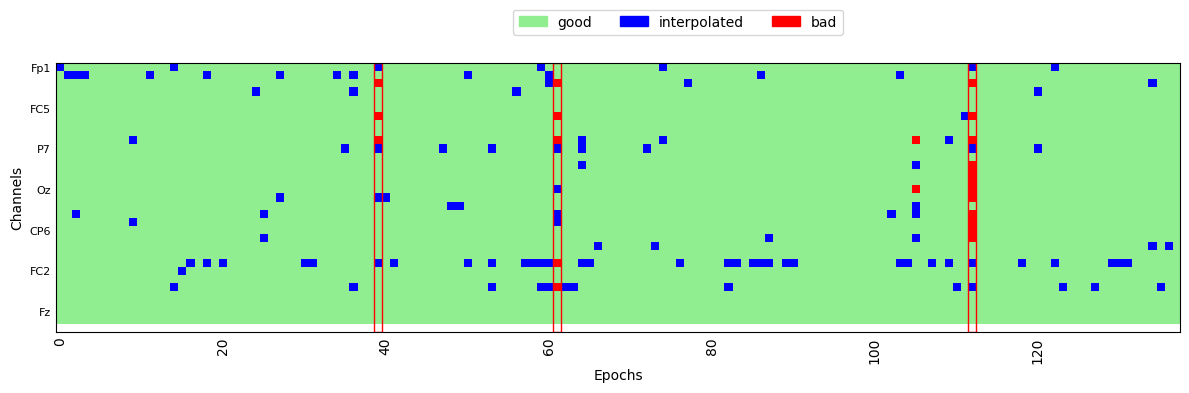

---
EPOCHS AFTER AR



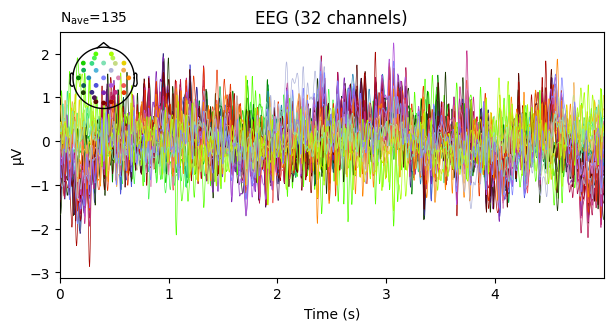

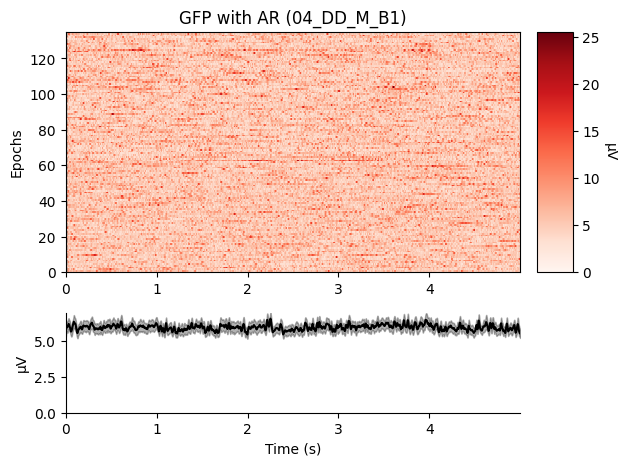

In [27]:
for i in range(len(file_dirs)):
    # Read in the raw EEG data
    raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                              stim_channel=stimulus_channel)
    
    # Set 'Erg1' as a miscellaneous channel
    raw.set_channel_types({'Erg1': 'misc'})  # assuming 'Erg1' is a miscellaneous channel

    # Set the right montage (Biosemi32) and set reference as average across all channels
    raw = raw.set_montage(mne.channels.make_standard_montage(montage)).load_data()\
             .set_eeg_reference(ref_channels=reference, verbose=True)

    # Find event markers for the start and end of recordings
    events = mne.find_events(raw, stim_channel=stimulus_channel, consecutive=False, output='offset')
    tminmax = [events[0][0]/raw.info['sfreq'], events[-1][0]/raw.info['sfreq']]

    # Use the markers to crop to EEG signal to leave only the actual task
    cropped_raw = raw.crop(tmin=tminmax[0], tmax=tminmax[1])
    cropped_raw = cropped_raw.drop_channels(stimulus_channel)
    print(('Event markers are following:\n{}\nStarting point: {} s\nEnding point: {} s\n'
           'Total duration: {} s').format(events, tminmax[0], tminmax[1], tminmax[1]-tminmax[0]))
    
    # Filter the signal with bandpass filter and remove EOG artefacts with SSP
    filt = pre_process.filter_raw_data(cropped_raw, filter_design, line_remove=None,
                                       eog_channels=eog_channels, plot_filt=False, savefig=False)

    # Divide the filtered signal to epochs and run Autoreject artefact rejection on the epochs
    %matplotlib inline
    epochs = pre_process.artefact_rejection(filt,subject_names[i],epo_duration=epochs_duration)

    # (Optional) for displaying interactive EEG plots to visually inspect the signal quality
    
   # %matplotlib qt
   # epochs.plot(n_channels=32,n_epochs=1)

    # Try to create a directory and save the EEG file to that directory
    try:
        os.makedirs(export_dir)
    except FileExistsError:
        pass
    try:
        mne.Epochs.save(epochs,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),
                                                                  overwrite=True)
    except FileExistsError:
        pass

## ERP detection and identification

In [34]:
tminmax = [-200, 1000]

# Time windows for different ERP components
erp_wins = {'N1' : [40, 170, -1],
            'N2' : [180, 350, -1],
            'P2' : [100, 260, 1],
            'P3' : [270, 500, 1]}

# Channel of interest
channel_picks = 'Pz'

# Event names (i.e. different stimuli) within the epochs
event_list = ['Grating end']

In [35]:
# Get directories of clean EEG files and set export directory
dir_inprogress = os.path.join(clean_folder, exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')

Files in Data/Clean/METACOG/Memory/B1 read in: 4


In [36]:
print(epochs.event_id)

{'1': 1}


In [37]:
# Loop through all the subjects' directories (EEG files directories)
df_erps = pd.DataFrame()
arrange.create_results_folders(exp_folder=exp_folder,results_folder=results_folder, erps=True)
for i in range(len(file_dirs)):
    erp_wins_temp = erp_wins
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]), verbose=False)
    
    # Apply baseline correction
    epochs = epochs.apply_baseline(baseline=(None, 0))

    ### create loop here for going through different stimuli separately
    for ev in event_list:
        print('{} for {} ({}/{})'.format(ev, subject_names[i], i, len(file_dirs)))
        # Create an averaged evoked object from epochs
        evoked_signal = epochs[ev].average(picks=channel_picks)

        # remove or add if save_evoked === truuuu
        evoked_signal.save('{}/{}/ERP analysis/{}_{}_{}_evoked-ave.fif'.format(results_folder, exp_folder,
                                                                            subject_names[i], channel_picks,
                                                                            ev), overwrite=True)

        # Find all the peaks in the evoked signal
        minpeak_times, minpeak_mags, maxpeak_times, maxpeak_mags = erpan.find_all_peaks(evoked_signal, epochs, 
                                                                                        t_range=tminmax, thresh=None,
                                                                                        subject_name=subject_names[i],
                                                                                        verbose=False, plot=False)
        
        # Identify which peaks are which ERPs based on the pre-defined ERP time windows
        erp_peaks, not_erp_peaks = erpan.identify_erps(evoked_signal, erp_wins_temp, minpeak_times, minpeak_mags,
                                                    maxpeak_times, maxpeak_mags, t_range=tminmax, subject_name=subject_names[i],
                                                    verbose=False, plot=True, savefig=False,
                                                    results_foldername=results_folder, exp_folder=exp_folder)

        # After visual inspection, it's possible to re-define the time windows to look for the peak
        while input('Do you need to do any manual time window changes? (leave empty if "no")') != '':
            print('Changing time window parameters for {}'.format(subject_names[i]))
            new_time_win = [None, None, None]

            # Ask user for which ERP they want to change or add
            erp_tochange = input('What ERP time window you want to change (e.g., N1)?')

            # Ask user what should be the minimum timepoint of the time window for that ERP
            new_time_win[0] = int(input('Enter MIN time of the window in interest for {} (e.g., 50)'.format(erp_tochange)))

            # Ask user what should be the maximum timepoint of the time window for that ERP
            new_time_win[1] = int(input('Enter MAX time of the window in interest for {} (e.g., 100)'.format(erp_tochange)))

            # Ask user whether this ERP should be a postitive (1) or negative (-1) peak
            new_time_win[2] = int(input('Enter whether to look for MIN (-1) or MAX (1) voltage for {}'.format(erp_tochange)))

            # Change the temporary ERP time window parameters to the user inputted parameters
            erp_wins_temp[erp_tochange] = new_time_win
            print('Changing', erp_tochange, 'with new time window:', str(new_time_win))

            # Use these new parameters to find either minimum or maximum value in that range
            try:
                erp_peaks = erpan.find_minmax_erp(evoked_signal, erp_peaks, erp_tochange, new_time_win,
                                                t_range=tminmax, subject_name=subject_names[i], verbose=False, plot=True,
                                                savefig=False, results_foldername=results_folder, exp_folder=exp_folder)
            except:
                print('Something went wrong with manual ERP detection, try again.')

        # Add this/these new temporary ERP to the main dataframe
        df_erps_temp = erpan.erp_dict_to_df(erp_peaks, erp_wins_temp, subject_names[i])
        df_erps_temp['Event'] = ev
        df_erps_temp['Channel'] = channel_picks
        df_erps = pd.concat([df_erps, df_erps_temp])
        print('ERPs have been found and added to the dataframe for {}'.format(subject_names[i]))
        display(df_erps)

# OPTIONAL Calculate relative peak-to-peak amplitudes between the ERPs
#   print('Adding relative amplitudes for N1-P2, P2-N2, N2-P3')
#   df_erps['N1-P2 amplitude'] = df_erps['P2 amplitude'] - df_erps['N1 amplitude']
#   df_erps['P2-N2 amplitude'] = df_erps['N2 amplitude'] - df_erps['P2 amplitude']
#   df_erps['N2-P3 amplitude'] = df_erps['P3 amplitude'] - df_erps['N2 amplitude']

# Export all the detected ERPs to an Excel spreadsheet
display(df_erps)
df_erps.to_excel('{}/{}/ERP analysis/{}_{}_grandaverage_erps.xlsx'.format(results_folder,exp_folder,exp_condition,channel_picks))

ValueError: Baseline interval is only one sample. Use `baseline=(0, 0)` if this is desired.

### DATA VISUALISATION: ERPs

In [ ]:
# Export the figure to results folder or not
savefig = True

# Subjects which to not plot
exclude_subjects = [] # ['OKTOS_0019', 'OKTOS_0024', 'OKTOS_0033']

# Channel of interest
ch = 'Pz'

# Event names (i.e. different stimuli) within the epochs
event_list = ['Grating end', 'Delay end']

In [ ]:
sns.set_theme(context='notebook', font_scale=1.3,
              style='whitegrid', palette='muted',
              font='sans-serif')

# Get directories of clean EEG files and exclude the pre-defined subjects
dir_inprogress = os.path.join(clean_folder, exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress, "_clean-epo.fif",
                                      exclude_subjects=exclude_subjects)

# Loop through all the subjects' directories (EEG files directories)
evoked_signal_go = [None]*len(file_dirs)
evoked_signal_nogo = [None]*len(file_dirs)
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress,
                                                                subject_names[i]),
                                                                verbose=False)
    
    # Create an averaged evoked object from epochs for both events
    evoked_signal_go[i] = epochs['GO trial'].average(picks=ch)
    evoked_signal_nogo[i] = epochs['NO-GO trial'].average(picks=ch)

# Average all the averaged evoked objects, thereby creating a grand average signals
go_master_grand_evoked_data = mne.grand_average(evoked_signal_go).data[0]*1e6
go_master_grand_evoked_times = mne.grand_average(evoked_signal_go).times*1e3
nogo_master_grand_evoked_data = mne.grand_average(evoked_signal_nogo).data[0]*1e6
nogo_master_grand_evoked_times = mne.grand_average(evoked_signal_nogo).times*1e3

# Plot all experiments' grand average signals on a single plot
fig, ax = plt.subplots(figsize=(6, 4), layout='tight', dpi=150)
ax.plot(go_master_grand_evoked_times, go_master_grand_evoked_data, linewidth=3)
ax.plot(nogo_master_grand_evoked_times, nogo_master_grand_evoked_data, linewidth=3)
ax.legend(event_list)
ax.set_title('Grand average of all participants at {}'.format(ch))
ax.set_xlim([-200, 1000])
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (µV)')
ax.grid(which='major', axis='y', alpha=0.2)
ax.grid(which='major', axis='x', alpha=0.7)
if savefig == True:
    plt.savefig(fname='{}/{}/GRAND_erpfig_{}.png'.format(results_folder, exp_folder, ch),
                dpi=300)
plt.show()